조엘 그루스, 2016, 인사이트, '밑바닥부터 시작하는 데이터 과학'

최적화 문제 - 모델의 오류를 최소화, 우도(likelihood)를 최대화에 경사하강법 적용

1) Y = X**2에서 Y가 가장 최소가 되는 지점은??

In [47]:
from linear_algebra import distance, vector_subtract, scalar_multiply, vector_sum, magnitude
from functools import partial, reduce
import random
import matplotlib.pyplot as plt

In [48]:
def step(v, direction, step_size):
    return [v_i + step_size * direction_i for v_i, direction_i in zip(v, direction)]

In [49]:
def squares(v):
    return [v_i**2 for v_i in v]
# X**2 의 도함수 -> v의 기울기값 도출
def sum_of_squares_gradient(v):
    return [2 * v_i for v_i in v]

In [50]:
#v = [random.randint(-2, 2) for i in range(1)] # 임의의 시작점
v = [-10, 100]
tolerance = 0.000001
move_history = list()
while True:
    gradient = sum_of_squares_gradient(v)
    next_v = step(v, gradient, -0.01)
    move_history.extend(next_v)
    if distance(next_v, v) < tolerance:
        break
    v = next_v

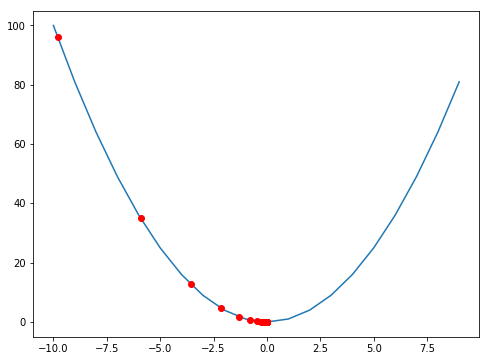

In [51]:
x = [a for a in range(-10,10)]
y = squares(x)
plt.figure(figsize=(8,6))
plt.plot(x,y)
move_v =[move_history[i] for i in range(0,len(move_history), 50)][:len(x)]
plt.plot(move_v,squares(move_v),'ro')

# batch gradient descent

In [52]:
def safe(f):
    """f에 오류가 발생하면 무한대를 반환"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')         # this means "infinity" in Python
    return safe_f

In [53]:
def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):

    theta = theta_0              # 시작점 초기화
    target_fn = safe(target_fn)  # 오류발생 시 처리를 위한 작업
    value = target_fn(theta)     # 초기화된 시작점을 대입하여 도출된 함수값

    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    while True:
        gradient = gradient_fn(theta)                   
        next_thetas = [step(theta, gradient, -step_size) 
                       for step_size in step_sizes]
 
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)

        if abs(value - next_value) < tolerance:
            return theta                     #값 도출하는 지점 
        else:
            theta, value = next_theta, next_value

In [54]:
def negate(f):
    '''-f를 반환'''
    return lambda *args, **kwargs: -f(*args, **kwargs)

def negate_all(f):
    '''f가 반환하는 모든 값을 음수로 변환'''
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]

def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
                          negate_all(gradient_fn),
                          theta_0,
                          tolerance)

# SGD(stochastic gradient descent)

In [55]:
def in_random_order(data):
    """임의의 순서대로 data에서 하나의 데이터 반환"""
    indexes = [i for i, _ in enumerate(data)]  
    random.shuffle(indexes)                    
    for i in indexes:                          
        yield data[i]
        
def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):

    data = list(zip(x, y))
    theta = theta_0                             
    alpha = alpha_0                             
    min_theta, min_value = None, float("inf")   
    iterations_with_no_improvement = 0

    while iterations_with_no_improvement < 100:
        value = sum( target_fn(x_i, y_i, theta) for x_i, y_i in data )

        if value < min_value:
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            iterations_with_no_improvement += 1
            alpha *= 0.9
            
        for x_i, y_i in in_random_order(data): # data에서 무작위로 하나 뽑는다.
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))

    return min_theta

In [56]:
def maximize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    return minimize_stochastic(negate(target_fn),
                               negate_all(gradient_fn),
                               x, y, theta_0, alpha_0)

# 예시 - 차원축소

데이터형태
 [[ 0.66637087  1.68694185]
 [ 2.471684   -5.08833963]
 [ 5.36840355  2.80514942]]


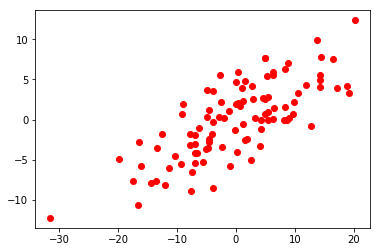

In [57]:
import numpy as np
import matplotlib.pyplot as plt
with open('./데이터/차원축소.txt') as f:
    임시 = f.readline().split(',')
    앞 = [float(임시[x]) for x in range(0,len(임시),2)]
    뒤 = [float(임시[x]) for x in range(1,len(임시),2)]
    np_X = np.array(list(zip(앞,뒤)))
print("데이터형태\n",np_X[:3])
plt.plot( np_X[:,0], np_X[:,1],"ro")
plt.show()

### 위 산포도에서 어떤 방향이 데이터의 편차를 가장 많이 잡아낼 수 있는가? 

크기1이면서 임의의 방향을 가리키는 벡터로 각 성분을 내적 -> 벡터의 크기를 제거하여 방향만 도출

-> 방향을 기준으로 각 성분의 편차가 최대(==내적이 최대)가 되게하는 벡터를 찾는다

In [58]:
# w벡터의 방향 도출
def direction(w):
    mag = magnitude(w)
    return [w_i / mag for w_i in w]
#데이터 하나의 편차
def directional_variance_i(x_i, w):
    return np.dot(x_i, direction(w)) ** 2
#모든 데이터의 편차 총합
def directional_variance(X, w):
    return sum(directional_variance_i(x_i, w) for x_i in X)
# 한 데이터의 편차 벡터화
def directional_variance_gradient_i(x_i, w):
    projection_length = np.dot(x_i, direction(w))
    return [2 * projection_length * x_ij for x_ij in x_i]
# 모든 데이터의 편차 총합의 벡터화
def directional_variance_gradient(X, w):
    return vector_sum(directional_variance_gradient_i(x_i,w) for x_i in X)

def first_principal_component(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_batch(
        partial(directional_variance, X),           
        partial(directional_variance_gradient, X),  
        guess)
    return direction(unscaled_maximizer)

In [59]:
guess = [1 for _ in np_X[0]]
unscaled_maximizer = maximize_batch(
    partial(directional_variance, np_X),           
    partial(directional_variance_gradient, np_X),  
    guess)

In [60]:
print("편차총합(벡터) :", unscaled_maximizer)
print("방향만 도출    :", direction(unscaled_maximizer))

편차총합(벡터) : [681698704.5221128, 282419191.9887005]
방향만 도출    : [0.9238554090431896, 0.382741666377781]


In [62]:
guess = [1 for _ in np_X[0]]
unscaled_maximizer = maximize_stochastic(
    lambda x, _, w: directional_variance_i(x, w),
    lambda x, _, w: directional_variance_gradient_i(x, w),
    np_X, [None for _ in np_X], guess)

In [63]:
print("편차총합(벡터) :", unscaled_maximizer)
print("방향만 도출    :", direction(unscaled_maximizer))

편차총합(벡터) : [2688721.3388525206, 1113453.4573007699]
방향만 도출    : [0.923910070424725, 0.3826096989985747]
